In [1]:
import os
import sys
import numpy as np
import pandas as pd
import subprocess
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

import itertools
from susipop import filter
from susipop import reader
from IPython.html.widgets import FloatProgress
from IPython.display import display
from ipywidgets import interactive
import ipywidgets as widgets
%matplotlib notebook

import plotly
import susipop as sp

from multiprocessing import Pool
from scipy.interpolate import griddata
def get_folder_list():
    f = next(os.walk('.'))[1]
    return f

/home/vsivadas/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Viscosity vs Average Cluster Size with explicit cluster gap definition

In [2]:
import seaborn as sns
from susipop.susi.cache import SusiCache as cache
label1 = widgets.Label("")
label_cache = widgets.Label(value = "")
progress_1 = widgets.IntProgress(min = 0, max = 100, value = 0)
progress_2 = widgets.IntProgress(min = 0, max = 100, value = 0)

def cluster_size_vs_viscosity_matplotlib(path_text_input,phis,shearrates,gaps, loglog,Individual_plots,min_t):    
    plt.style.use("ggplot")
    if not Individual_plots:
        plt.figure(figsize=[10,5])
    else:
#         matplotlib.rcParams.update({'font.size': 8})
        plt.figure(figsize=[4.5*len(shearrates),5*len(phis)],dpi=100)
        
    for g,gap in enumerate(gaps):
        n_fig = 0
        s_data = np.asarray([])
        ns_data = np.asarray([])
        viscosity_temp = np.asarray([])
        N_typical = np.asarray([])
        for p,phi in enumerate(phis):
            for k,shearrate in enumerate(shearrates):
                n_fig += 1
                progress_2.value = int(float(n_fig)*(g+1)/(len(shearrates)*len(phis)*len(gaps))*100)
                if Individual_plots: N_typical, viscosity_temp = np.asarray([]),np.asarray([])
                try:
                    if len(path_text_input.strip())== 0:
                        path = "rhor1_phi"+str(phi)+"_yd"+str(float(shearrate))
                    else:
                        path = str(path_text_input)+"/rhor1_phi"+str(phi)+"_yd"+str(float(shearrate))

                    dataset = sp.reader.DataSet(path,particles=True, fluid=False)
                    print len(dataset.tlist), "steps available"

                    cache_file = cache(cachefile=dataset.cachefile)
                    viscosity_file = pd.read_csv(path+"/result/nu_t.dat")
                    viscosity = np.array(viscosity_file[viscosity_file.columns[4]][1:])
                    for i,t in enumerate(dataset.tlist[1:len(viscosity)]):
                        progress_1.value = int(float(i)/len(dataset.tlist[1:len(viscosity)])*100)
                        try:
                            if cache_file.has_data(t,"cluster_size_distribution_gap_"+str(gap)):
                                if i > min_t:
                                    label_cache.value = "loading data for t="+str(t)
                                    s, ns = cache_file.load_data(t,"cluster_size_distribution_gap_"+str(gap))
                                    idx = np.where(ns != 0)[0]
                                    s_data = np.concatenate([s_data , s[idx]])
                                    ns_data = np.concatenate([ns_data , ns[idx]])
                                    N_typical_temp = np.asarray([sum(np.multiply(s,ns))/float(sum(ns))])
                                    N_typical = np.concatenate([N_typical, N_typical_temp]) 
                                    viscosity_temp = np.concatenate([viscosity_temp, [viscosity[i]]])
                                    label1.value = str(s[idx])
                                    
                            else:
                                dataset.load_state(t)
                                s, ns = dataset.get_quantity("cluster_size_distribution", gap = gap, update=True)
                                cache_file.save_data(t,{"cluster_size_distribution_gap_"+str(gap):[s, ns]})
                                idx = np.where(ns != 0)[0]
                                s_data = np.concatenate([s_data , s[idx]])
                                ns_data = np.concatenate([ns_data , ns[idx]])
                                N_typical_temp = np.asarray([sum(np.multiply(s,ns))/float(sum(ns))])
                                N_typical = np.concatenate([N_typical, N_typical_temp]) 
                                viscosity_temp = np.concatenate([viscosity_temp, [viscosity[i]]])
                                label1.value = str(s[idx])
                        except Exception as e:
                            print e
                    try:
                        if Individual_plots:
                            nx_plots = len(phis)
                            ny_plots = len(shearrates)
                            plt.subplot(nx_plots, ny_plots,n_fig)
                            print (p+1)*(k+1)
                            x_val = N_typical
                            y_val = viscosity_temp
                            plt.xlabel("Average cluster size N",fontsize=20)
                            if n_fig ==1 : plt.ylabel("relative viscosity ",fontsize=20)
#                             plt.rcParams['axes.tickweight'] = 'bold'
                            plt.xticks(fontsize=16)
                            plt.yticks(fontsize=16)
                            if loglog:
                                plt.plot(x_val,y_val,'.',label="gap="+str(gap))
                                plt.xscale("log")
                                plt.yscale("log")
                                plt.xlim([1,1e3])
                                plt.ylim([1,1e5])
                            else:
                                plt.plot(x_val,y_val,'.',label="gap="+str(gap))
                            plt.xlim([1,1e3])
                            plt.ylim([1,1e5])
                            plt.legend(loc="best",fontsize=16)
                            plt.title("$\phi=$"+str(phi)+" $\dot{\gamma}=$"+str(shearrate),fontsize=20)
                    except Exception as e:
                        continue
                        
                except Exception as e:
                    print e
#         uniq_sizes = np.unique(s_data)
#         ns_data_cumulative = np.zeros_like(uniq_sizes)
#         for i, item in enumerate(uniq_sizes):
#             idx_uniq = np.where(s_data == item)[0]
#             ns_data_cumulative[i] = sum(ns_data[idx_uniq])
            
#         x,y = uniq_sizes, ns_data_cumulative
        if not Individual_plots:
            x,y = N_typical, viscosity_temp
            plt.xlabel("Average cluster size N")
            plt.ylabel("relative viscosity ")    
            plt.subplot(121)
            if loglog:
                plt.loglog(x,  y,'.',label="gap="+str(gap))
            else:
                plt.plot(x,  y,'.',label="gap="+str(gap))
            plt.xlim([1,1e3])
            plt.ylim([0,1e5])
            plt.legend()

            plt.subplot(122)
            N_uniq = np.unique(N_typical)
            viscosity_temp_mean = []
            viscosity_temp_var = []
            for N in N_uniq:
                N_idx = np.where(x==N)[0]
                print N_idx
                viscosity_temp_mean.append(np.mean(y[N_idx]))
                viscosity_temp_var.append(np.var(y[N_idx]))
#             print N_uniq
#             print viscosity_temp_mean
#             print viscosity_temp_var
            plt.errorbar(N_uniq,viscosity_temp_mean,yerr=viscosity_temp_var,label="gap="+str(gap))
    #         sns.regplot(x=x, y=y, x_bins=30, fit_reg=None)
            if loglog:
                plt.xscale("log")
                plt.yscale("log")
            plt.legend()
            plt.xlabel("cluster size N")
            plt.ylabel("relative viscosity ")
            plt.xlim([1,1e3])
            plt.ylim([1,1e5])
    plt.tight_layout()
#         plt.loglog(x,  y/float(max(y)), linewidth=1.0,label="gap="+str(gap))
#     plt.legend(loc="best")
#     plt.xlabel("N_typical")
#     plt.ylabel("relative viscosity")
#     plt.suptitle("cluster size vs rel. viscosity for phi "+str(phi)+" yd"+str(shearrates)+" gap="+str(gaps))
    
    
widget_cluster_size_vs_viscosity_matplotlib = interactive(cluster_size_vs_viscosity_matplotlib, \
    path_text_input = widgets.Text(value="larger_system_size/from_cartesius/F_CL_2e-10/"),\
    phis = widgets.SelectMultiple(options=[40,45,50,54,55,56,58],value=[56]), \
    shearrates= widgets.SelectMultiple(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000],value=[10,11.5,13,30]),\
    gaps = widgets.SelectMultiple(options=[9e-8,6.7e-8,4e-8,1e-8], value = [9e-8,6.7e-8,4e-8]),\
    loglog = widgets.RadioButtons(options=[True,False],value = True),\
    Individual_plots = widgets.RadioButtons(options=[True,False],value = True),\
    min_t = widgets.IntText(value=50),                                                     
    __manual = True)
# display(widget_cluster_size_vs_viscosity_matplotlib)
display(widget_cluster_size_vs_viscosity_matplotlib.children[0])
display(widgets.HBox(widget_cluster_size_vs_viscosity_matplotlib.children[1:4]))
display(widgets.HBox(widget_cluster_size_vs_viscosity_matplotlib.children[4:]))
display(label1)
display(progress_2)
display(progress_1)
display(label_cache)
# for i,item in enumerate(pdf_average.children):
#     print i, item.description 
# display(widget_cluster_size_distribution_matplotlib)
# display(widgets.HBox(cluster_size_distribution.children[4:]))

# Cluster size vs Cluster Probability  with explicit cluster gap definition

<IPython.core.display.Javascript object>


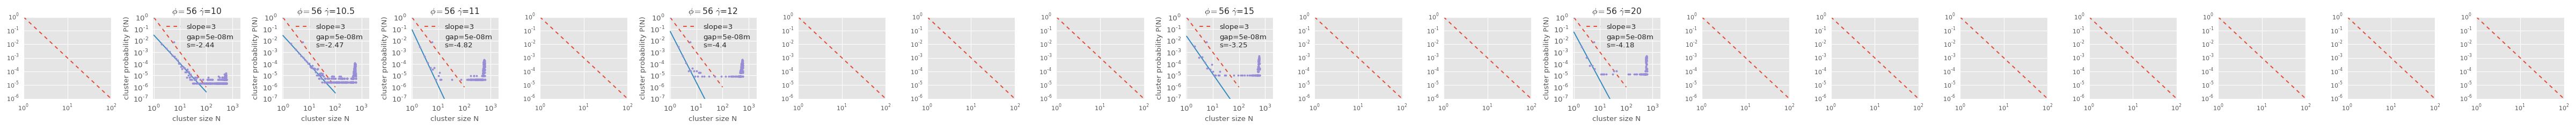

[Errno 2] No such file or directory: './larger_viscosity/larger_viscosity_1x_F_CL_2e-10//rhor1_phi56_yd1.0/config.json'
1002 steps available
2
[1, 2, 3, 4, 5, 6, 7, 8, 9]
1 9 -2.44288147032 -1.52366873021
2001 steps available
3
[1, 2, 3, 4, 5, 6, 7, 8, 9]
1 9 -2.47404425943 -1.55339712962
2002 steps available
4
[1, 2, 3]
1 3 -4.82183173406 -1.0611030335
[Errno 2] No such file or directory: './larger_viscosity/larger_viscosity_1x_F_CL_2e-10//rhor1_phi56_yd11.5/config.json'
1002 steps available
6
[1, 2, 3]
1 3 -4.39766917258 -1.20636936625
[Errno 2] No such file or directory: './larger_viscosity/larger_viscosity_1x_F_CL_2e-10//rhor1_phi56_yd12.5/config.json'
[Errno 2] No such file or directory: './larger_viscosity/larger_viscosity_1x_F_CL_2e-10//rhor1_phi56_yd13.0/config.json'
[Errno 2] No such file or directory: './larger_viscosity/larger_viscosity_1x_F_CL_2e-10//rhor1_phi56_yd14.0/config.json'
1002 steps available
10
[1, 2, 3, 4]
1 4 -3.24554632215 -1.62137906684
[Errno 2] No such file

/home/vsivadas/.local/lib/python2.7/site-packages/ipykernel/__main__.py:143: RankWarning:

Polyfit may be poorly conditioned



In [2]:
import os
import sys
import numpy as np
import pandas as pd
import subprocess
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

import itertools
from susipop import filter
from susipop import reader
from IPython.html.widgets import FloatProgress
from IPython.display import display
from ipywidgets import interactive
import ipywidgets as widgets
%matplotlib notebook

import plotly
import susipop as sp

from multiprocessing import Pool

def get_folder_list():
    f = next(os.walk('.'))[1]
    return f

import seaborn as sns
from susipop.susi.cache import SusiCache as cache
label1 = widgets.Label("")
label_cache = widgets.Label(value = "")
progress_1 = widgets.IntProgress(min = 0, max = 100, value = 0)
progress_2 = widgets.IntProgress(min = 0, max = 100, value = 0)

def cluster_size_vs_probability_matplotlib(path_text_input,phis,shearrates,gaps, loglog,Individual_plots,viscosity_range,\
                                           fit_exponential,exponential_range,fitting_method,idx_range,manual_slope, 
                                           manual_offset,marker,fig_size,slope_line=True,normalize=False,highdpi=False):    
    plt.style.use("ggplot")
    if not Individual_plots:
        plt.figure(figsize=[10,5],dpi=300)
    else:
#         matplotlib.rcParams.update({'font.size': 8})
        if highdpi : plt.figure(figsize=[fig_size*len(shearrates),fig_size*len(phis)],dpi=300)
        else: plt.figure(figsize=[fig_size*len(shearrates),fig_size*len(phis)])
        nx_plots = len(phis)
        ny_plots = len(shearrates)
        if slope_line:
            for plot_id in range(1,nx_plots*ny_plots+1):
                plt.subplot(nx_plots,ny_plots,plot_id)
                plt.loglog([10**(val) for val in np.linspace(0,2,10)],[10**(-3*val+0) for val in np.linspace(0,2,10)],"--",label="slope=3")
    for g,gap in enumerate(gaps):
        n_fig = 0
        s_data = np.asarray([])
        ns_data = np.asarray([])
        for p,phi in enumerate(phis):
            for k,shearrate in enumerate(shearrates):
                n_fig += 1
                progress_2.value = int(float(n_fig)*(g+1)/(len(shearrates)*len(phis)*len(gaps))*100)
                if Individual_plots: s_data, ns_data = np.asarray([]), np.asarray([])
                try:
                    if len(path_text_input.strip())== 0:
                        path = "rhor1_phi"+str(phi)+"_yd"+str(float(shearrate))
                    else:
                        path = str(path_text_input)+"/rhor1_phi"+str(phi)+"_yd"+str(float(shearrate))

                    dataset = sp.reader.DataSet(path,particles=True, fluid=False)
                    npart = float(dataset.npart)
                    print len(dataset.tlist), "steps available"

                    cache_file = cache(cachefile=dataset.cachefile)
                    viscosity_file = pd.read_csv(path+"/result/nu_t.dat")
                    viscosity = np.array(viscosity_file[viscosity_file.columns[4]][1:])
                    idx_visc = np.where((viscosity <= viscosity_range[1]) & (viscosity >= viscosity_range[0]))[0]
#                     print idx_visc
#                     print 
#                     for i,t in enumerate([dataset.tlist[i]  for i in [i ifidx_visc]):
                    for i,t in enumerate([dataset.tlist[i] for i in idx_visc]):
                        progress_1.value = int(float(i)/len([dataset.tlist[i] for i in idx_visc])*100)
                        try:
                            if cache_file.has_data(t,"cluster_size_distribution_gap_"+str(gap)):
                                label_cache.value = "loading data for t="+str(t)
                                s, ns = cache_file.load_data(t,"cluster_size_distribution_gap_"+str(gap))
                                idx = np.where(ns != 0)[0]
                                s_data = np.concatenate([s_data , s[idx]])
                                ns_data = np.concatenate([ns_data , ns[idx]])
                                label1.value = str(s[idx])
                            else:
                                dataset.load_state(t)
                                label_cache.value = "saving data for t="+str(t)
                                s, ns = dataset.get_quantity("cluster_size_distribution", gap = gap, update=True)
                                cache_file.save_data(t,{"cluster_size_distribution_gap_"+str(gap):[s, ns]})
                                idx = np.where(ns != 0)[0]
                                s_data = np.concatenate([s_data , s[idx]])
                                ns_data = np.concatenate([ns_data , ns[idx]])
                                label1.value = str(s[idx])
                        except Exception as e:
                            print e 
                            continue
                    
                    try:
                        if Individual_plots:
                            uniq_sizes = np.unique(s_data)
                            ns_data_cumulative = np.zeros_like(uniq_sizes)
                            for i, item in enumerate(uniq_sizes):
                                idx_uniq = np.where(s_data == item)[0]
                                ns_data_cumulative[i] = sum(ns_data[idx_uniq])
                            ns_temp_tot = ns_data_cumulative
                            nx_plots = len(phis)
                            ny_plots = len(shearrates)
                            
                            plt.subplot(nx_plots, ny_plots,n_fig)
                            
                            print (p+1)*(k+1)
                            if loglog:
                                slopestring = ""
                                x_log_unsorted = np.log10(uniq_sizes)
                                y_log_unsorted = np.log10(ns_data_cumulative/float(max(ns_data_cumulative)))
                                y_log = [yi for (xi,yi) in sorted(zip(x_log_unsorted,y_log_unsorted))]
                                x_log = np.sort(x_log_unsorted)
                                #fitting line to powerlaw---------------------------------------------------------------------
                                if fit_exponential:
                                    if fitting_method=="use_idx_range":
                                        n1,n2 = idx_range[0],idx_range[1]
                                        m,b = np.polyfit(x_log[n1:n2], y_log[n1:n2], 1)
#                                         n1_n2_idx = np.where((y_log >= -4) &  (x_log < 2))[0]
                                        
                                    elif fitting_method=="manual":
                                        m,b = float(manual_slope), float(manual_offset)
                                        n1,n2 = idx_range[0],idx_range[1]
                                        print "asdas",m,b
                                    elif fitting_method=="use_exponential_range":
                                        n1_n2_idx = []
                                        for i in range(len(x_log)):
                                            if x_log[i] < 2:
                                                if y_log[i] > exponential_range[0]:
                                                    if y_log[i] < exponential_range[1]:
                                                        n1_n2_idx.append(i)
    #                                                 print i 
                                        print n1_n2_idx
                                        n1_n2_idx = np.asarray(n1_n2_idx)
                                        n2 = max(n1_n2_idx)
                                        n1 = max(min(n1_n2_idx),1)
                                        m,b = np.polyfit(x_log[n1:n2], y_log[n1:n2], 1)
                                    
                                    print n1,n2,m,b
#                                     print x_log[n1:n2], "asdasd d",y_log[n1:n2]
#                                     m,b = np.polyfit(x_log[n1_n2_idx], y_log[n1_n2_idx], 1)
#                                     m,b = np.polyfit(x_log[n1:n2], y_log[n1:n2], 1)
                                    
                                    plt.loglog([10**(val) for val in np.linspace(0,2,10)],[10**(m*val+b) for val in np.linspace(0,2,10)])
                                    slopestring = "\ns="+str(round(m,2))
                                #fitting line to powerlaw ends----------------------------------------------------------
                                if not normalize:
                                    plt.loglog(uniq_sizes,ns_data_cumulative/float(max(ns_data_cumulative)),marker,label="gap="+str(gap)+"m"+slopestring)
                                else:
                                    plt.loglog([i/npart for i in uniq_sizes],ns_data_cumulative/float(max(ns_data_cumulative)),marker,label="gap="+str(gap)+"m"+slopestring)
#                                 plt.loglog(uniq_sizes,ns_data_cumulative/float(max(ns_data_cumulative)),label="gap="+str(gap))

                            else:
                                plt.plot(uniq_sizes,ns_data_cumulative/float(max(ns_data_cumulative)),marker,label="gap="+str(gap))
#                                 plt.plot(uniq_sizes,ns_data_cumulative/float(max(ns_data_cumulative)),label="gap="+str(gap))
#                             if fit_exponential:
                                
                                
                            plt.xlabel("cluster size N")
                            plt.ylabel("cluster probability P(N)")
                            plt.xticks(fontsize=12)
                            plt.yticks(fontsize=12)
                            if not normalize:
                                plt.xlim([0.9,2e3])
                                plt.ylim([1e-7,1.1])
                            else:
                                plt.xlim([0,1.1])
                                plt.ylim([1e-7,1.1])
                            plt.legend(loc="best",fontsize=12)
#                             plt.title("$\phi=$"+str(phi)+" $\dot{\gamma}$="+str(shearrate)+" rel.viscosity: "+str(viscosity_range),fontsize=10)
                            plt.title("$\phi=$"+str(phi)+" $\dot{\gamma}$="+str(shearrate),fontsize=14)

                    except Exception as e:
                        continue
                        
                except Exception as e:
                    print e

        if not Individual_plots:
            uniq_sizes = np.unique(s_data)
            ns_data_cumulative = np.zeros_like(uniq_sizes)
            for i, item in enumerate(uniq_sizes):
                idx_uniq = np.where(s_data == item)[0]
                ns_data_cumulative[i] = sum(ns_data[idx_uniq])
            x,y = uniq_sizes, ns_data_cumulative
            
            if loglog:
                plt.loglog(x,  y/float(max(y)),marker)
                plt.loglog(x,  y/float(max(y)),label="gap="+str(gap)+"m")
            else:
                plt.plot(x,  y/float(max(y)),marker)
                plt.plot(x,  y/float(max(y)),label="gap="+str(gap)+"m")
            plt.xlabel("cluster size N")
            plt.ylabel("cluster probability ")
            plt.legend(loc="best")
    plt.tight_layout()
    
    
widget_cluster_size_vs_probability_matplotlib = interactive(cluster_size_vs_probability_matplotlib, \
    path_text_input = widgets.Text(value="./larger_viscosity/larger_viscosity_1x_F_CL_2e-10/"),\
    phis = widgets.SelectMultiple(options=[40,45,50,54,55,56,58],value=[55]), \
    shearrates= widgets.SelectMultiple(options=[1,10,10.5,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000],value=[10,15,20,70]),\
    gaps = widgets.SelectMultiple(options=[9e-8,5e-8,1e-8], value = [5e-8]),\
    loglog = widgets.RadioButtons(options=[True,False],value = True),\
    Individual_plots = widgets.RadioButtons(options=[True,False],value = True),\
    viscosity_range = widgets.IntRangeSlider(min=1,max=1e6,value=[1,1000000]),\
    fit_exponential = widgets.ToggleButtons(options=[True,False],value = True),\
    exponential_range = widgets.FloatRangeSlider(description = "probability range of exponential regime for fitting",value = [-4,-1], min= -8, max = 0),\
    idx_range =  widgets.IntRangeSlider(value = [1,10], min = 0, max= 30),\
    fitting_method = widgets.ToggleButtons(options=["use_exponential_range","use_idx_range","manual"],
                                           value = "use_exponential_range"),
    manual_slope = widgets.FloatText(value=-3,min=-100,max=1e6),\
    manual_offset = widgets.FloatText(value=-1,min=-100,max=1e6),\
    marker = widgets.Text(value="o"), 
    fig_size = widgets.FloatText(value="3",min=0),
    __manual = True)
# display(widget_cluster_size_vs_viscosity_matplotlib)
display(widget_cluster_size_vs_probability_matplotlib.children[0])
display(widgets.HBox(widget_cluster_size_vs_probability_matplotlib.children[1:4]))
display(widgets.HBox(widget_cluster_size_vs_probability_matplotlib.children[4:-11]))
display(widgets.HBox(widget_cluster_size_vs_probability_matplotlib.children[-11:-7]))
display(widgets.HBox(widget_cluster_size_vs_probability_matplotlib.children[-7:-4]))
display(widgets.HBox(widget_cluster_size_vs_probability_matplotlib.children[-4:]))
display(label1)
display(progress_2)
display(progress_1)
display(label_cache)
# for i,item in enumerate(pdf_average.children):
#     print i, item.description 
# display(widget_cluster_size_distribution_matplotlib)
# display(widgets.HBox(cluster_size_distribution.children[4:]))

# Gaps vs shear stress

## analyze

<IPython.core.display.Javascript object>


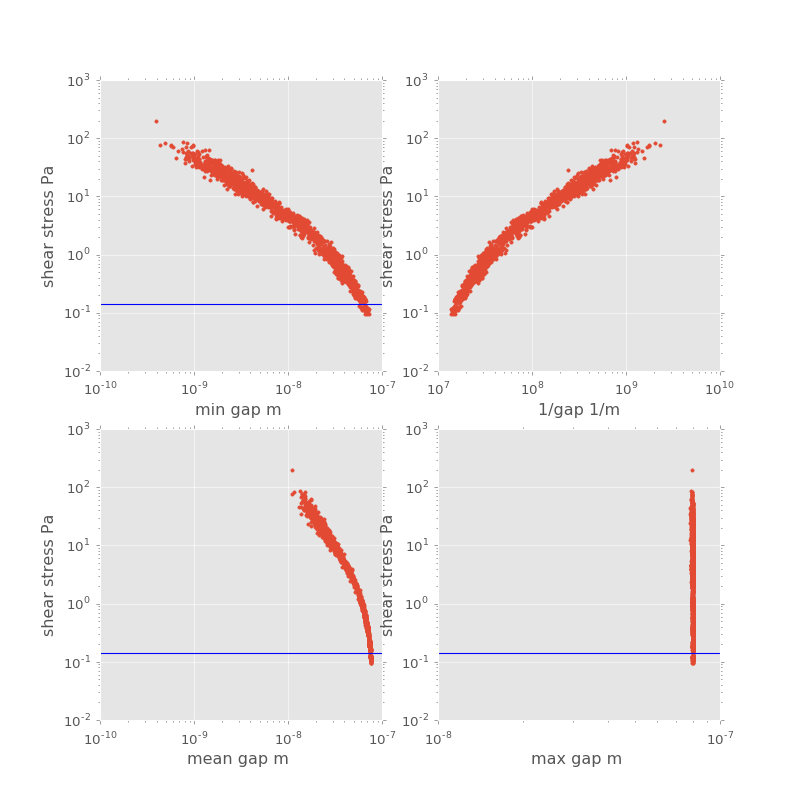

<IPython.core.display.Javascript object>


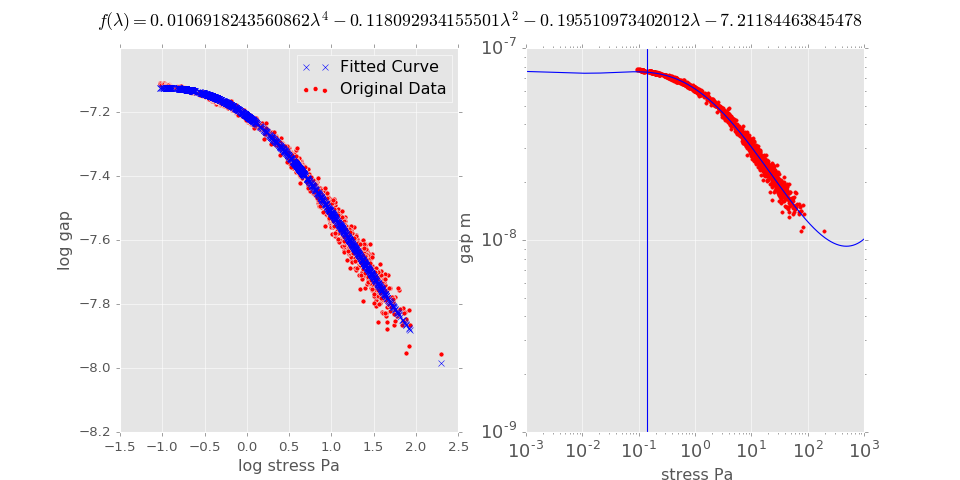

[33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,

In [11]:
import matplotlib.cm as cm

progress_g_ss = widgets.Label(value = "")
display(progress_g_ss)
progress_bar = widgets.IntProgress(min=0,max=100,value=0)
display(progress_bar)
def get_gap_shear_stress(path_add,phi,yd,t):
#     path_add = "larger_system_size/from_cartesius/F_CL_2e-10/"
#     path_add = ""
    path = path_add +"rhor1_phi"+str(phi)+"_yd"+str(yd)+"/"
    dataset = reader.DataSet(path, particles=True, fluid=False)
    viscosity_file = pd.read_csv(path+"result/nu_t.dat")
    viscosity = viscosity_file[viscosity_file.columns[2]]
    dataset.load_state(dataset.tlist[t])
    shear_stress = viscosity[t-1]*yd
    r = dataset.particles.r
    radius = dataset.particles.radius
    def gap(i,j):
        return np.linalg.norm(r[i]-r[j])-radius[i] - radius[j]
    gaps = []
    for i in range(dataset.npart):
        for j in range(dataset.npart):
            if j > i:
                gap_ij = gap(i,j)
                if gap_ij<8e-8:
                    gaps.append(gap_ij)
#     return np.mean(gaps), shear_stress
    return np.min(gaps),np.mean(gaps),np.max(gaps), shear_stress


def gap_analysis(path_add,phis, shearrates,time_step):
    global gaps, ss, mean_gap, max_gap, col,min_gap    
    gaps,ss = [],[]
    mean_gap, max_gap = [], []
#     colors = cm.rainbow(np.linspace(0, 1, len(shearrates)*len(phis)))
    col = []
    col_ = 0
    for p in phis:
#     for p in [40,45,50,54,55,56]:
#         for y in [float(i) for i in range(10,100,5)]:
        for y in shearrates:
            col_ += 1
            for i in range(50,1000,time_step):
                try:
                    min_g,mean_g,max_g,s = get_gap_shear_stress(path_add,p,y,i)
                    progress_g_ss.value = str(p)+", "+ str(y) + " completed="+str(float(i)/1000.0*100)+"%"
                    progress_bar.value = int(float(i)/1000.0*100)
                    gaps.append(min_g)
                    mean_gap.append(mean_g)
                    max_gap.append(max_g)
                    ss.append(s)
                    col.append(col_)
                except Exception as e:
#                     print e
                    continue
    min_gap = gaps
    return ss,min_gap,mean_gap,max_gap,col


def plot_gaps_vs_shearstress(path_add,phis, shearrates,time_step,analyze):
    import matplotlib.pyplot as plt
    if analyze:
        ss,min_gap,mean_gap,max_gap,col = gap_analysis(path_add,phis, shearrates,time_step)
    gaps=min_gap
    plt.figure(figsize=[10,10])
    plt.style.use("ggplot")
    plt.subplot(221)
    plt.loglog(gaps, ss, '.')
    plt.axhline(0.14)
    plt.xlabel("min gap m ")
    plt.ylabel("shear stress Pa")
    plt.xlim([1e-10, 1e-7])
    plt.subplot(222)
    plt.loglog([1.0/i for i in gaps], ss, '.')
    plt.xlabel("1/gap 1/m")
    plt.ylabel("shear stress Pa")
    # plt.xlim([1e-10, 1e-7])
    plt.subplot(223)
    plt.loglog(mean_gap, ss, '.')
    plt.axhline(0.14)
    plt.xlabel("mean gap m ")
    plt.ylabel("shear stress Pa")
    plt.xlim([1e-10, 1e-7])
    plt.subplot(224)
    plt.loglog(max_gap, ss, '.')
    plt.axhline(0.14)
    plt.xlabel("max gap m ")
    plt.ylabel("shear stress Pa")
    # plt.xlim([1e-10, 1e-7])
    # -*- coding: utf-8 -*-

    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit
    import numpy as np
    import sympy as sym

    """
    Generate some data, let's imagine that you already have this. 
    """
    # y = [1.0/(i) for i in gaps]
    # y = gaps
    y = [np.log10(i) for i in mean_gap]
    # y = [i for i in gaps]
    # x = ss
    x = [np.log10(i) for i in ss]

    """
    Plot your data
    """
    plt.figure(figsize=[12,6])
    plt.subplot(121)
#     plt.plot(x, y, 'ro',label="Original Data")
    
#     plt.scatter(x,y,c=col,label="Original Data")
    plt.scatter(x,y,c='r',label="Original Data")
    print col
#     plt.gray()
    """
    brutal force to avoid errors
    """    
    x = np.array(x, dtype=float) #transform your data in a numpy array of floats 
    y = np.array(y, dtype=float) #so the curve_fit can work

    """
    create a function to fit with your data. a, b, c and d are the coefficients
    that curve_fit will calculate for you. 
    In this part you need to guess and/or use mathematical knowledge to find
    a function that resembles your data
    """
    def func(x, a, b, c, d):
        return a*x**4 + b*x**2 +c*x + d

    # def func(x, a, b,c):
    #     return a*2.718281828459045**(x*-b)+c
    """
    make the curve_fit
    """
    popt, pcov = curve_fit(func, x, y)

    """
    The result is:
    popt[0] = a , popt[1] = b, popt[2] = c and popt[3] = d of the function,
    so f(x) = popt[0]*x**3 + popt[1]*x**2 + popt[2]*x + popt[3].
    """
    print "a = %s , b = %s, c = %s, d = %s" % (popt[0], popt[1], popt[2], popt[3])
    # print "a = %s , b = %s, c = %s" % (popt[0], popt[1], popt[2])
    """
    Use sympy to generate the latex sintax of the function
    """
    xs = sym.Symbol('\lambda')    
    tex = sym.latex(func(xs,*popt)).replace('$', '')
    plt.suptitle(r'$f(\lambda)= %s$' %(tex),fontsize=16)

    """
    Print the coefficients and plot the funcion.
    """

    plt.plot(x, func(x, *popt),'bx', label="Fitted Curve") #same as line above \/
    #plt.plot(x, popt[0]*x**3 + popt[1]*x**2 + popt[2]*x + popt[3], label="Fitted Curve") 

    plt.legend(loc='best')
    plt.xlabel("log stress Pa")
    plt.ylabel("log gap")
    plt.show()

    def predict_gap(shear_stress):
        i = shear_stress
        log_gap = popt[0]*np.log10(i)**4 +popt[1]*np.log10(i)**2 +popt[2]*np.log10(i) +popt[3]
        return 10**(log_gap)

    # plt.figure()
    plt.subplot(122)
    # plt.plot([np.log(i) for i in ss],[np.log(i) for i in gaps],'r.')
    # plt.loglog(ss,gaps,'r.')
    plt.loglog(ss,mean_gap,'r.')
    fit_gap = [ predict_gap(i) for i in np.linspace(1e-2,1e3,100000)]
    # log_ss = [np.log(i) for i in ss]
    # plt.plot(log_ss,fit,'b.')
    plt.plot(np.linspace(1e-3,1e3,100000),fit_gap,'b')
    plt.xlabel(" stress Pa")
    plt.ylabel(" gap m")
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.axvline(0.14)
    
widget_plot_gaps_vs_shearstress = interactive(plot_gaps_vs_shearstress, \
    path_add = widgets.Text(value="./larger_viscosity/larger_viscosity_1x_F_CL_2e-10/",description="path"),\
    phis = widgets.SelectMultiple(options=[40,45,50,54,55,56,58]), \
    shearrates= widgets.SelectMultiple(options=[1.0,10.0,10.5,11.0,11.5,12.0,12.5,13.0,14.0,15.0,16.0,18,20.0,30.0,\
                                                50.0,70.0,100.0,200.0,300.0,1000.0]),\
    time_step = widgets.IntText(value=10),\
    analyze = widgets.ToggleButtons(options=[True,False], value= True),\
    __manual = True)
display(widgets.HBox(widget_plot_gaps_vs_shearstress.children[:-3]))
display(widgets.HBox(widget_plot_gaps_vs_shearstress.children[-3:]))

## plot

In [6]:
plt.figure(figsize=[10,10])
plt.style.use("classic")
plt.subplot(221)
plt.loglog(gaps, ss, '.')
plt.axhline(0.14)
plt.xlabel("min gap m ")
plt.ylabel("shear stress Pa")
plt.xlim([1e-10, 1e-7])
plt.subplot(222)
plt.loglog([1.0/i for i in gaps], ss, '.')
plt.xlabel("1/gap 1/m")
plt.ylabel("shear stress Pa")
# plt.xlim([1e-10, 1e-7])
plt.subplot(223)
plt.loglog(mean_gap, ss, '.')
plt.axhline(0.14)
plt.xlabel("mean gap m ")
plt.ylabel("shear stress Pa")
plt.xlim([1e-10, 1e-7])
plt.subplot(224)
plt.loglog(max_gap, ss, '.')
plt.axhline(0.14)
plt.xlabel("max gap m ")
plt.ylabel("shear stress Pa")
# plt.xlim([1e-10, 1e-7])
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import sympy as sym


plt.figure(figsize=[12,6])
plt.subplot(121)
plt.plot(x, y, 'ro',label="Original Data")
x = np.array(ss, dtype=float)
y = np.array(mean_gap, dtype=float)
def func(t,a,b,c,d,e): return a+b*np.log(t)+ c*np.log(t)**2+ d*np.log(t)**3+ e*np.log(t)**4
def predict_gap(shear_stress):
    log_gap = func(shear_stress, *popt)
    return np.exp(log_gap)

popt, pcov = curve_fit(func, x, np.log(y))
print popt
plt.loglog(np.linspace(x.min(),x.max(),1000), np.exp(func(np.linspace(x.min(),x.max(),1000), *popt)),'b.', label="Fitted Curve") 
plt.legend(loc='best')
plt.xlabel("log stress Pa")
plt.ylabel("log gap")
plt.show()




plt.subplot(122)
plt.loglog(ss,mean_gap,'r.')
print np.mean(mean_gap)
# fit_gap = [ predict_gap(i) for i in np.linspace(1e-2,1e3,100000)]
fit_gap = predict_gap(np.linspace(1e-2,1e3,1000))
plt.plot(np.linspace(1e-3,1e3,1000),fit_gap,'b.')
plt.xlabel(" stress Pa")
plt.ylabel(" gap m")
plt.axvline(0.14)

plt.suptitle("log(y) = {:3f} + {:3f}log(x) +{:3f}log(x)^2 + {:3f}log(x)^3 + {:3f}log(x)^4".format(*popt))

<IPython.core.display.Javascript object>

NameError: name 'gaps' is not defined

# Cluster Analysis with gap as a function of shear stress

<IPython.core.display.Javascript object>


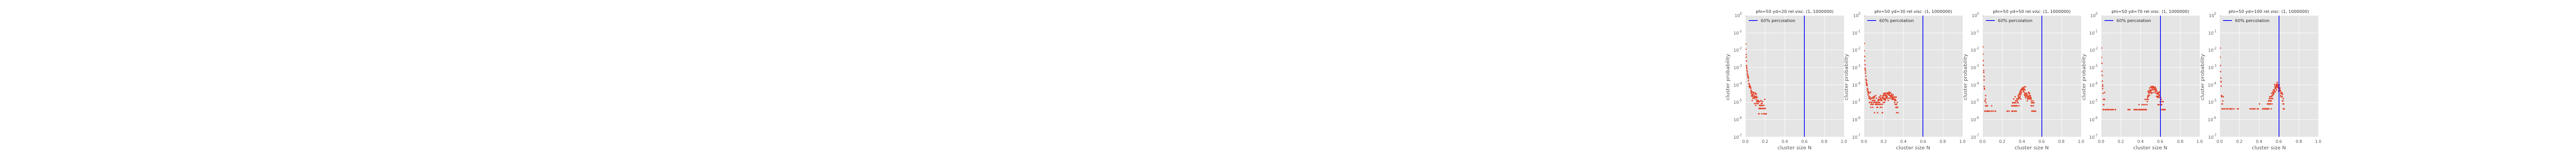

[Errno 2] No such file or directory: './larger_viscosity/larger_viscosity_1x_F_CL_2e-10//rhor1_phi50_yd1.0/config.json'
[Errno 2] No such file or directory: './larger_viscosity/larger_viscosity_1x_F_CL_2e-10//rhor1_phi50_yd10.0/config.json'
[Errno 2] No such file or directory: './larger_viscosity/larger_viscosity_1x_F_CL_2e-10//rhor1_phi50_yd10.5/config.json'
[Errno 2] No such file or directory: './larger_viscosity/larger_viscosity_1x_F_CL_2e-10//rhor1_phi50_yd11.0/config.json'
[Errno 2] No such file or directory: './larger_viscosity/larger_viscosity_1x_F_CL_2e-10//rhor1_phi50_yd11.5/config.json'
[Errno 2] No such file or directory: './larger_viscosity/larger_viscosity_1x_F_CL_2e-10//rhor1_phi50_yd12.0/config.json'
[Errno 2] No such file or directory: './larger_viscosity/larger_viscosity_1x_F_CL_2e-10//rhor1_phi50_yd12.5/config.json'
[Errno 2] No such file or directory: './larger_viscosity/larger_viscosity_1x_F_CL_2e-10//rhor1_phi50_yd13.0/config.json'
[Errno 2] No such file or directo

In [5]:
import os
import sys
import numpy as np
import pandas as pd
import subprocess
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

import itertools
from susipop import filter
from susipop import reader
from IPython.html.widgets import FloatProgress
from IPython.display import display
from ipywidgets import interactive
import ipywidgets as widgets
%matplotlib notebook

import plotly
import susipop as sp

from multiprocessing import Pool

def get_folder_list():
    f = next(os.walk('.'))[1]
    return f
import seaborn as sns
from susipop.susi.cache import SusiCache as cache

label1 = widgets.Label("")
label_cache = widgets.Label(value = "")
progress_1 = widgets.IntProgress(min = 0, max = 100, value = 0)
progress_2 = widgets.IntProgress(min = 0, max = 100, value = 0)

a =  -1.66069590e+01
b = -1.81914112e-01
c =  -5.19980443e-02 
d = -3.80706433e-03
e =  1.67153515e-03
popt = [a,b,c,d,e]
def func(t,a,b,c,d,e): return a+b*np.log(t)+ c*np.log(t)**2+ d*np.log(t)**3+ e*np.log(t)**4
def predict_gap(shear_stress):
    log_gap = func(shear_stress, *popt)
    return np.exp(log_gap)

# def predict_gap(shear_stress):
#     if shear_stress > 0.14:
#         log_gap = func(shear_stress, *popt)
#         return np.exp(log_gap)
#     else:
#         return 1e-10

def cluster_size_vs_probability_dynamic_gap(path_text_input,phis,shearrates, loglog,Individual_plots,viscosity_range,\
                                            normalize=True):    
    plt.style.use("ggplot")
    if not Individual_plots:
        plt.figure(figsize=[6,3],dpi=150)
    else:
#         matplotlib.rcParams.update({'font.size': 8})
        plt.figure(figsize=[5*len(shearrates),5*len(phis)])

    n_fig = 0
    s_data = np.asarray([])
    ns_data = np.asarray([])
    for p,phi in enumerate(phis):
        for k,shearrate in enumerate(shearrates):
            n_fig += 1
            progress_2.value = int(float(n_fig)/(len(shearrates)*len(phis))*100)
            if Individual_plots: s_data, ns_data = np.asarray([]), np.asarray([])
            try:
                if len(path_text_input.strip())== 0:
                    path = "rhor1_phi"+str(phi)+"_yd"+str(float(shearrate))
                else:
                    path = str(path_text_input)+"/rhor1_phi"+str(phi)+"_yd"+str(float(shearrate))
                dataset = sp.reader.DataSet(path,particles=True, fluid=False)
                print len(dataset.tlist), "steps available"
                npart = dataset.npart
                cache_file = cache(cachefile=dataset.cachefile)
                viscosity_file = pd.read_csv(path+"/result/nu_t.dat")
                viscosity = np.array(viscosity_file[viscosity_file.columns[4]][1:])
                viscosity_non_relative = np.array(viscosity_file[viscosity_file.columns[2]][1:])
                idx_visc = np.where((viscosity <= viscosity_range[1]) & (viscosity >= viscosity_range[0]))[0]
                for i,t in enumerate([dataset.tlist[j] for j in idx_visc]):
                    progress_1.value = int(float(i)/len(idx_visc)*100)
                    try:
                        if cache_file.has_data(t,"cluster_size_distribution_dynamic_gap"):
                            label_cache.value =  "loading data for t="+str(t)+ " phi"+ str(phi)+" yd"+str(shearrate)
                            s, ns = cache_file.load_data(t,"cluster_size_distribution_dynamic_gap")
                            idx = np.where(ns != 0)[0]
                            s_data = np.concatenate([s_data , s[idx]])
                            ns_data = np.concatenate([ns_data , ns[idx]])
                            label1.value = str(s[idx])
                        else:
                            label_cache.value = "saving data for t="+str(t)+ " phi"+ str(phi)+" yd"+str(shearrate)
                            dataset.load_state(t)
                            shear_stress = viscosity_non_relative[idx_visc[i]]*shearrate

                            gap = predict_gap(shear_stress)
                            print shear_stress, gap, i
                            s, ns = dataset.get_quantity("cluster_size_distribution", gap = gap, update=True)
                            cache_file.save_data(t,{"cluster_size_distribution_dynamic_gap":[s, ns]})
                            idx = np.where(ns != 0)[0]
                            s_data = np.concatenate([s_data , s[idx]])
                            ns_data = np.concatenate([ns_data , ns[idx]])
                            label1.value = str(s[idx])
                    except Exception as e:
                            print e 
                            continue

                try:
                    if Individual_plots:
                        uniq_sizes = np.unique(s_data)
                        ns_data_cumulative = np.zeros_like(uniq_sizes)
                        for i, item in enumerate(uniq_sizes):
                            idx_uniq = np.where(s_data == item)[0]
                            ns_data_cumulative[i] = sum(ns_data[idx_uniq])
                        ns_temp_tot = ns_data_cumulative
                        nx_plots = len(phis)
                        ny_plots = len(shearrates)

                        plt.subplot(nx_plots, ny_plots,n_fig)
                        print (p+1)*(k+1)
                        if loglog:
                            if not normalize: 
                                plt.loglog(uniq_sizes,ns_data_cumulative/float(sum(ns_data_cumulative)),'.')
                            else:
                                plt.loglog(uniq_sizes/float(npart),ns_data_cumulative/float(sum(ns_data_cumulative)),'.')
                        else:
                            if not normalize:
                                plt.plot(uniq_sizes,ns_data_cumulative/float(sum(ns_data_cumulative)),'.')
                                plt.yscale("log")
                            else:
                                plt.plot(uniq_sizes/float(npart),ns_data_cumulative/float(sum(ns_data_cumulative)),'.')
                                plt.yscale("log")
                        #plotting a vertical line at 60% cluster percolation
                        if not normalize: 
                            plt.axvline(x=0.6*npart,label="60% percolation")
                        else:
                            plt.axvline(x=0.6,label="60% percolation")
                        plt.xlabel("cluster size N")
                        plt.ylabel("cluster probability ")
                        if not normalize:
                            plt.xlim([1,2e3])
                        else: 
                            plt.xlim([0,1])
                        plt.ylim([1e-7,1])
                        plt.legend(loc="best")
                        plt.title("phi="+str(phi)+" yd="+str(shearrate)+" rel.visc: "+str(viscosity_range),fontsize=10)
                    else:
                        mpl.rcParams.update({'font.size': 12})
                        
                        uniq_sizes = np.unique(s_data)
                        ns_data_cumulative = np.zeros_like(uniq_sizes)
                        for i, item in enumerate(uniq_sizes):
                            idx_uniq = np.where(s_data == item)[0]
                            ns_data_cumulative[i] = sum(ns_data[idx_uniq])
                        ns_temp_tot = ns_data_cumulative
                        nx_plots = len(phis)
                        ny_plots = len(shearrates)

                        print (p+1)*(k+1)
                        if loglog:
                            if not normalize:
                                plt.loglog(uniq_sizes,ns_data_cumulative/float(sum(ns_data_cumulative)),'k.')
                            else:
                                plt.loglog(uniq_sizes/float(npart),ns_data_cumulative/float(sum(ns_data_cumulative)),'k.',markersize=5)
                        else:
                            plt.plot(uniq_sizes,ns_data_cumulative,'.')
                        plt.xlabel("cluster size N")
                        plt.ylabel("cluster probability ")
                        plt.xticks(fontsize=12)
                        plt.yticks(fontsize=12)
#                         plt.xlim([1,2e3])
                        plt.ylim([1e-7,5])
                        plt.legend(loc="best")
#                         plt.title("phi="+str(phi)+" yd="+str(shearrate)+" rel.visc: "+str(viscosity_range),fontsize=10)
                except Exception as e:
                    continue

            except Exception as e:
                print e

    if not Individual_plots:
        uniq_sizes = np.unique(s_data)
        ns_data_cumulative = np.zeros_like(uniq_sizes)
        ns_data_sd = np.zeros_like(uniq_sizes)
        for i, item in enumerate(uniq_sizes):
            idx_uniq = np.where(s_data == item)[0]
            ns_data_cumulative[i] = sum(ns_data[idx_uniq])
            ns_data_sd[i] = np.std(ns_data[idx_uniq])
        x,y = uniq_sizes, ns_data_cumulative

        if loglog:
            plt.plot(x/float(npart),  y/float(sum(y)))
        else:
            plt.plot(x,  y/float(sum(y)),'o')
            plt.plot(x,  y/float(sum(y)),linewidth=0.1)
        plt.xscale("log")
        plt.yscale("log")
        
        if normalize: 
            plt.xlabel("normalized cluster size N")
        else:
            plt.xlabel("cluster size N")
            
        plt.ylabel("cluster probability ")
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        
        mpl.rcParams.update({'font.size': 14})
        plt.legend(loc="best")
        plt.tight_layout()
    
    
widget_cluster_size_vs_probability_dynamic_gap = interactive(cluster_size_vs_probability_dynamic_gap, \
    path_text_input = widgets.Text(value="./larger_viscosity/larger_viscosity_1x_F_CL_2e-10/"),\
    phis = widgets.SelectMultiple(options=[40,45,50,54,55,56,58], value = [40,45,50,54,55,56]), \
    shearrates= widgets.SelectMultiple(options=[1,10,10.5,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000], 
                                       value=[1,10,10.5,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100]),\
    loglog = widgets.RadioButtons(options=[True,False],value = True),\
    Individual_plots = widgets.RadioButtons(options=[True,False],value = False),\
    viscosity_range = widgets.IntRangeSlider(min=1,max=1e6,value=[1,100000]),\
    __manual = True)
# display(widget_cluster_size_vs_viscosity_matplotlib)
display(widget_cluster_size_vs_probability_dynamic_gap.children[0])
display(widgets.HBox(widget_cluster_size_vs_probability_dynamic_gap.children[1:4]))
display(widgets.HBox(widget_cluster_size_vs_probability_dynamic_gap.children[4:]))
display(label1)
display(progress_2)
display(progress_1)
display(label_cache)
# for i,item in enumerate(pdf_average.children):
#     print i, item.description 
# display(widget_cluster_size_distribution_matplotlib)
# display(widgets.HBox(cluster_size_distribution.children[4:]))